# Homework 3 Rosini Micol


## Coloring

In [115]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import math
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Utils cell for generic function

def create_neighbours(W):
    neighbours=[]
    for row in W:
        neighbours_node = []
        for idx, value in enumerate(list(row)):
            if value == 1:
                neighbours_node.append(idx)
        neighbours.append(neighbours_node)
    return neighbours

In [113]:
# Utils for plots

def create_plot(x,y,pos,time_color,n):
    
    fig, ax = plt.subplots(x,y, figsize = (10,15) , dpi=120)
    
    for t in range(x):
        #plt.subplot(x,y,t+1)
        nx.draw(G, pos,  with_labels=True, node_color = time_color[t], ax = ax[t])
        ax[t].set_title(f'Time-step {t}',fontsize=16)
    plt.savefig(f'fig2/graph{n}.png')
    fig.suptitle("Simulation of the learning dynamics", fontsize=20)
    
def create_figure(G,n,title, pos,node_color= 'lightskyblue',node_size = 300,figsize = (10,5)):
    fig, ax = plt.subplots(figsize = figsize, dpi=120)
    nx.draw(G,pos,with_labels=True, node_color= node_color, ax = ax, node_size = node_size)
    plt.savefig(f'fig2/graph{n}.png')
    fig.suptitle(title, fontsize=18)
    plt.show()
    
def triple_plot(n_steps,title_big,n, PLOTS):
    #fig, ax = plt.subplots(1, 3, figsize = [24,5], dpi = 120)
    fig, ax = plt.subplots(figsize = [24,5], dpi = 120)
    
    X = np.arange(n_steps)
    COLORS = ["dodgerblue", "orangered", "lime"]
    TITLES = ["Test 1", "Test 2", "Test 3"]


    for i, (color, y, title) in enumerate(zip(COLORS,PLOTS,TITLES)):

        ax.step(X, y, where='mid', label=title, color=color)
        ax.plot(X, y, 'o--', color='grey', alpha=0.3)
        ax.grid(axis='x', color='0.95')
        ax.set_xticks(X)
        ax.set_xlabel("Iteration",fontstyle = "italic", size = 9)
        ax.set_ylabel("U", fontstyle = "italic", size = 9)
        ax.legend()
        plt.savefig(f'fig1/graph{n}.png')
        ax.set_title(title, fontsize =13)
    fig.suptitle(title_big, fontsize =13)    
    plt.show()
    
    

def U_plot(PLOT,n, COLORS = ["orangered", "lightgreen", "aqua"]):
    
    fig,ax = plt.subplots(figsize=(40,20),dpi=120)
    
    for i, (color, y) in enumerate(zip(COLORS, PLOT)):
        ax.plot(np.arange(1002), y, color = color,linewidth=3, label = f'Test {i+1}')

    ax.set_xlabel("Iterations", fontsize = 40, fontstyle='italic')
    ax.set_xlim(left = 0.0)

    ax.set_ylabel("Potential function", fontsize = 40, fontstyle='italic')
    ax.set_ylim(bottom = 0.0)
    
    ax.set_yticklabels(np.arange(0,300,50),fontsize= 30)
    ax.set_xticklabels(np.arange(0,1000,100),fontsize= 30)



    ax.legend(fontsize = 30)
    ax.grid()

    fig.suptitle('Plot of U for different tested cases', fontsize=50)
    plt.savefig(f'fig2/graph{n}.png')



    plt.show()

In [108]:
# Utils cell for learning dynamics

def potential_function(G,neighbours,states_color):
    
    to_add = 0
    for i in range(len(G.nodes())):
        for neighbour in neighbours[i]:
            if states_color[neighbour] == states_color[i]:
                to_add +=  1
    U = 0.5 * to_add
    return U

def potential_function_2(G,neighbours,states_color, dict_of_colors):
    
    to_add = 0
    for i in range(len(G.nodes())):
        for neighbour in neighbours[i]:
            if states_color[neighbour] == states_color[i]:
                to_add +=  2
            elif abs(dict_of_colors[states_color[neighbour]]-dict_of_colors[states_color[i]]) == 1:
                 to_add += 1
    U = 0.5 * to_add
    return U

def create_prob_distribution(G,colors,neighbours,states_color,t):
    eta = t/100
    P=[]
    for i in range(len(G.nodes)):
        den = 0
        num = []
        for indx,color in enumerate(colors):
            n_nodes_of_color = 0
            for neighbour in neighbours[i]:
                if states_color[neighbour] == color:
                     n_nodes_of_color += 1
            to_add = np.exp(-eta*n_nodes_of_color)
            den += to_add
            num.append(to_add)
        P.append(num/den)
    return P    
        
def create_prob_distribution_modified(G,colors,neighbours,states_color,t,dict_of_colors, index_eta):
    
    
    ETA_dictionary = {0: t/100, 1:0.001, 2: 100, 3: np.exp(t/1000) , 4: np.log(t+2),5:np.sqrt(t)}
    eta = ETA_dictionary[index_eta]  
    
   
        
        
    P=[]
    for i in range(len(G.nodes)):
        den = 0
        num = []
        for indx,color in enumerate(colors):
            n_nodes_of_color = 0
            for neighbour in neighbours[i]:
                if states_color[neighbour] == color:
                     n_nodes_of_color += 2
                elif abs(dict_of_colors[states_color[neighbour]]-dict_of_colors[color]) == 1:
                     n_nodes_of_color += 1
            to_add = np.exp(-eta*n_nodes_of_color)
            den += to_add
            num.append(to_add)
        P.append(num/den)
    return P  



def learning_dynamics(G,neighbours,states_color, colors,  routers = False, dict_of_COLORS = None, index_eta = 0):
    
    all_times_color = [] # Keeps track of all the nodes' colors for each time step during the simulation
    time_color = [] # Keeps track of the specific nodes' colors for the current time-step
    
    for node in states_color.keys():
        time_color.append(states_color[node])
    all_times_color.append(time_color)

    time = 0
    min_U = 100
    all_u = []
    
    # Simulation of the learning dynamic
    while True:
        
        node = np.random.choice(G.nodes()) # Choose randomly a node
        if not routers: 
            P = create_prob_distribution(G,colors,neighbours,states_color,time) # probability distribution
            
        else:  
            P = create_prob_distribution_modified(G,colors,neighbours,states_color,time,dict_of_COLORS, index_eta)
            
        color = np.random.choice(colors, p = P[node])
        states_color[node] = color # Update the state color
        time_color = []
        
        for node in states_color.keys():
            time_color.append(states_color[node])

        all_times_color.append(time_color)
        
        if not routers:    
            U = potential_function(G,neighbours,states_color)
            
            if U == 0:
                break
            else:
                time+= 1
        else:
            
            U = potential_function_2(G,neighbours,states_color,dict_of_COLORS)
            all_u.append(U)
            if U < min_U :
                
                min_U = U
                min_time_color = time_color
                min_time = time
                if min_U == 0:
                    break
            elif time > 1000:
                break
                    
               
            time += 1
        
    if not routers:        
        print('solution found at time-step:',time + 1)
        if time <= 15: # If the time is short, we can directly see how the algorithm works in the figure above
            create_plot(len(all_times_color),1,pos,all_times_color,2)
    else:
        print('Potential function = ', U, '\nfound at time:',min_time)
        return min_time_color,all_u

## Exercise a
Simulate a learning dynamics with a line graph of 10 nodes. The set of possible states is C = {red, green}. At initialization, each node is red. Every discrete time instance t, one node $I(t)$, chosen uniformly at random, wakes up and updates its color.
The new color (resulting from a node’s update), is chosen from a probability distribution given by:

$$ P(X_i(t+1)=a | X(t),I(t)=i) =  \frac{e^{-\eta(T) \sum_j W_{ij}c(a,X_j(t))}} {\sum_{s\in C} e^{-\eta(t)\sum_j W_{ij}c(s,X_j(t))}}$$

where the cost is given by:

$$ c(s,X_j(t)) = 
\begin{cases} 
1 \quad &\text{if} \ X_j(t) = s\\
0 \quad &\text{otherwise} \\
\end{cases}
$$

Use $\eta(t) = \frac{t}{100}$
The potential function is:

$$U(t) = \frac{1}{2} \sum_{i,j \in \mathcal{V}} c(X_i(t), X_j(t)) $$
If the potential is zero, there are no conflicting nodes and a solution is found.


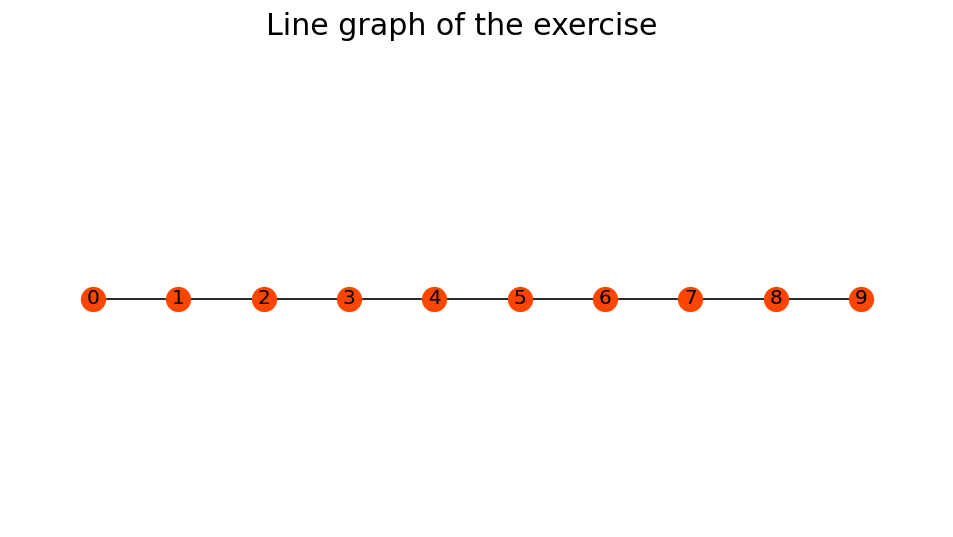

In [151]:
nodes = np.arange(10)
G = nx.Graph()
G.add_nodes_from(nodes)
edges = []

# Line graph

for i in range(9):
    edges.append((i,i+1))
pos= {i:(x,0) for i,x in zip(range(10),range(-5,5))}
G.add_edges_from(edges)
create_figure(G,1,'Line graph of the exercise', pos,node_color= 'orangered',node_size = 200)    

solution found at time-step: 7


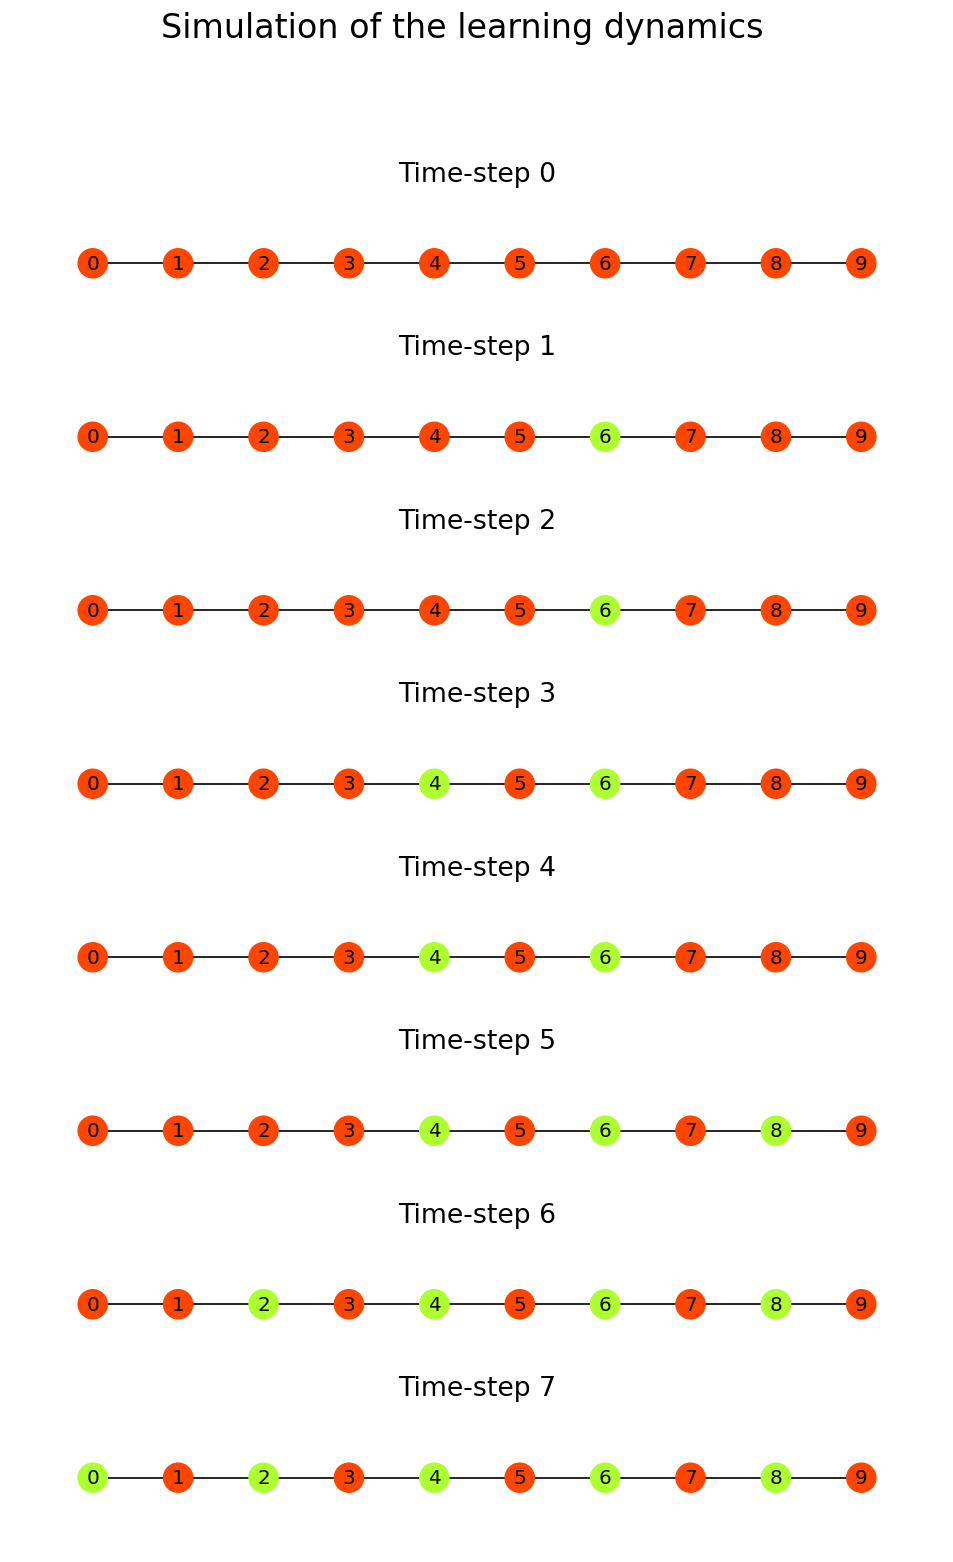

In [124]:
W = np.array(nx.convert_matrix.to_numpy_matrix(G))
pos= {i:(x,0) for i,x in zip(range(10),range(-5,5))}
n_steps = 20
colors = ['orangered','greenyellow']
states_color = {i:'orangered' for i in G.nodes() } # Dictionary with nodes as keys and their colors as values
neighbours = create_neighbours(W) 
learning_dynamics(G,neighbours,states_color,colors)

## Exercise b
Now, repeat the same learning dynamics, for the problem of assigning wifi-channels to 100 routers.  Here, a link between two nodes means that the two routers are able to interfere with each other. 
The cost function is equal to:


$$c(s,X_j(t)) = 
\begin{cases} 
2 \quad &\text{if} \ X_j(t) = s \\
1 \quad &\text{if} \ |X_j(t)-s| = 1\\
0 \quad &\text{otherwise} \\
\end{cases}
$$

and the set of possible colors 

$$C = \{ 1 : red,2 : green,3 : blue,4 : yellow,5 : magenta,6 : cyan,7 : white,8 : black\}$$

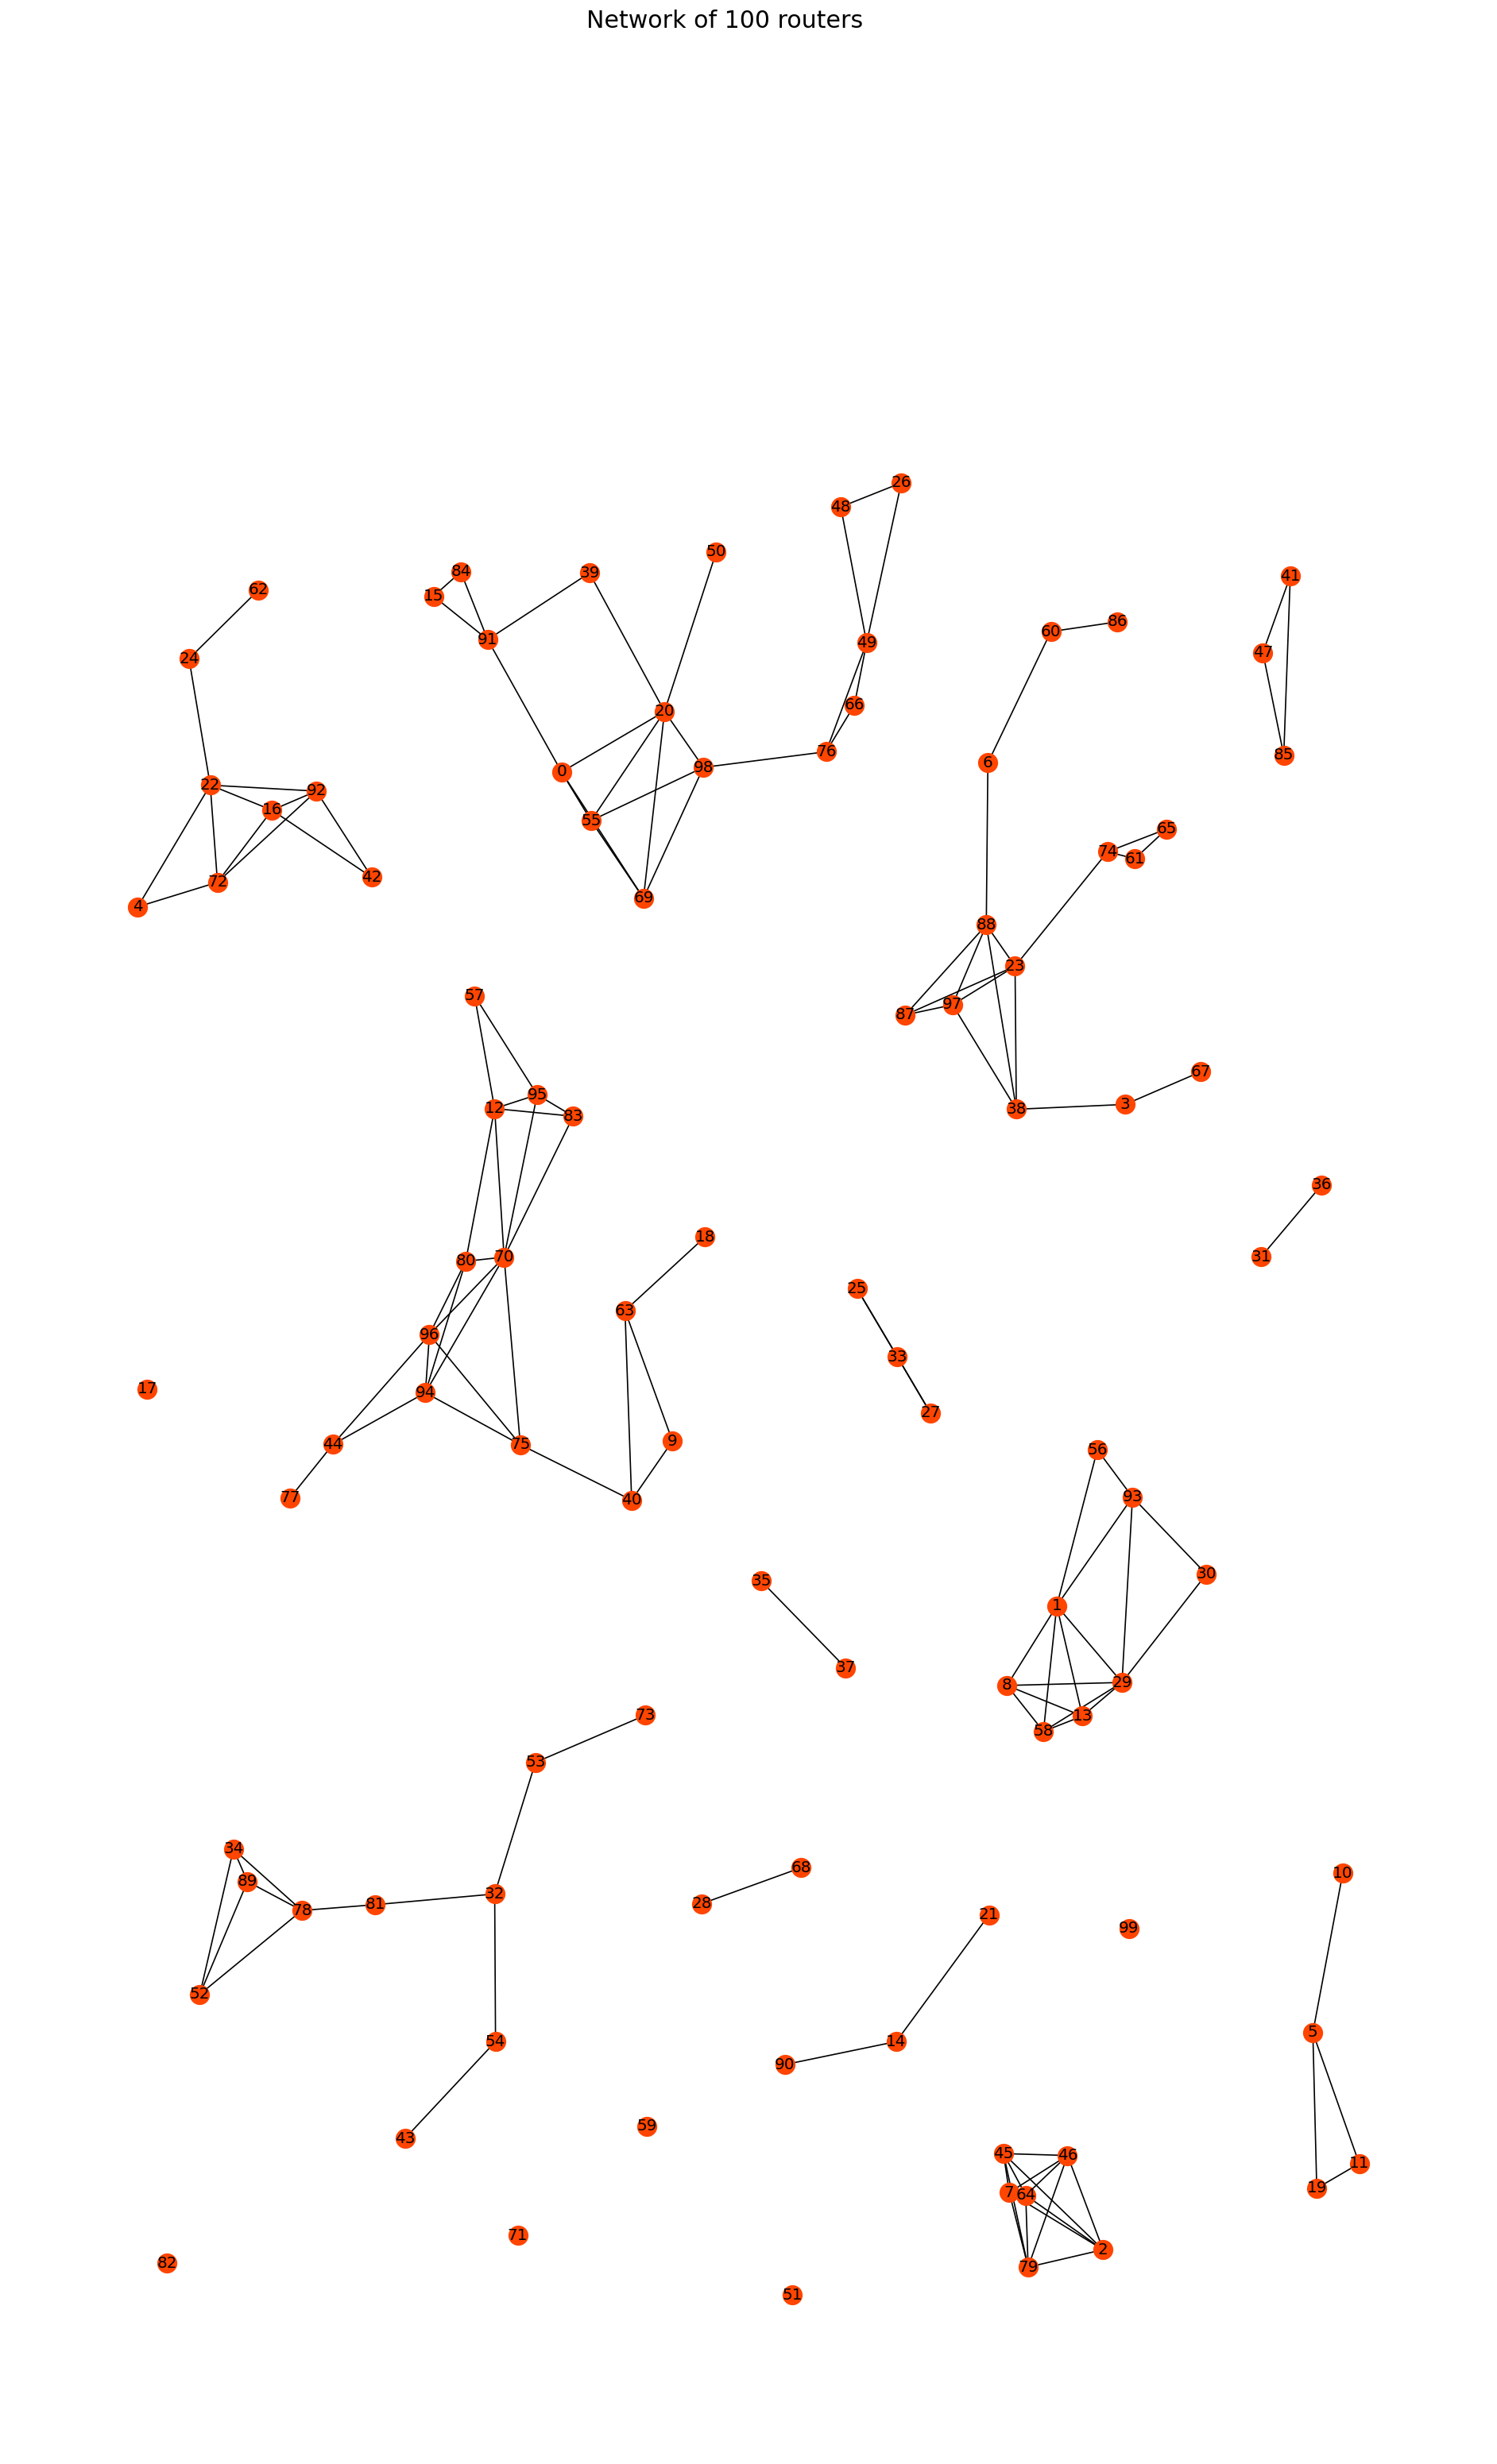

In [6]:
dict_of_COLORS = {'orangered':1,'greenyellow':2,'royalblue':3, 'yellow':4, 'magenta':5 , 'cyan':6 ,'white':7  ,'black':8 }
colors = ['orangered','greenyellow','royalblue','yellow', 'magenta', 'cyan','white' ,'black']
W = np.array(np.loadtxt('wifi.mat'))
POS =list( np.loadtxt('coords.mat'))
nodes = np.arange(100)
neighbours = create_neighbours(W)

# Creating the graph of the exercise

G = nx.Graph()
G.add_nodes_from(nodes)
edges = []
for i in range(len(G.nodes)):
    for neighbour in neighbours[i]:
        if (neighbour,i) not in edges:
            edges.append((i,neighbour))
            
G.add_edges_from(edges)

create_figure(G,3,'Network of 100 routers', POS ,node_color= 'orangered',node_size = 200,figsize = (20,30))    

Potential function =  4.0 
found at time: 953
Potential function =  4.0 
found at time: 948
Potential function =  4.0 
found at time: 658


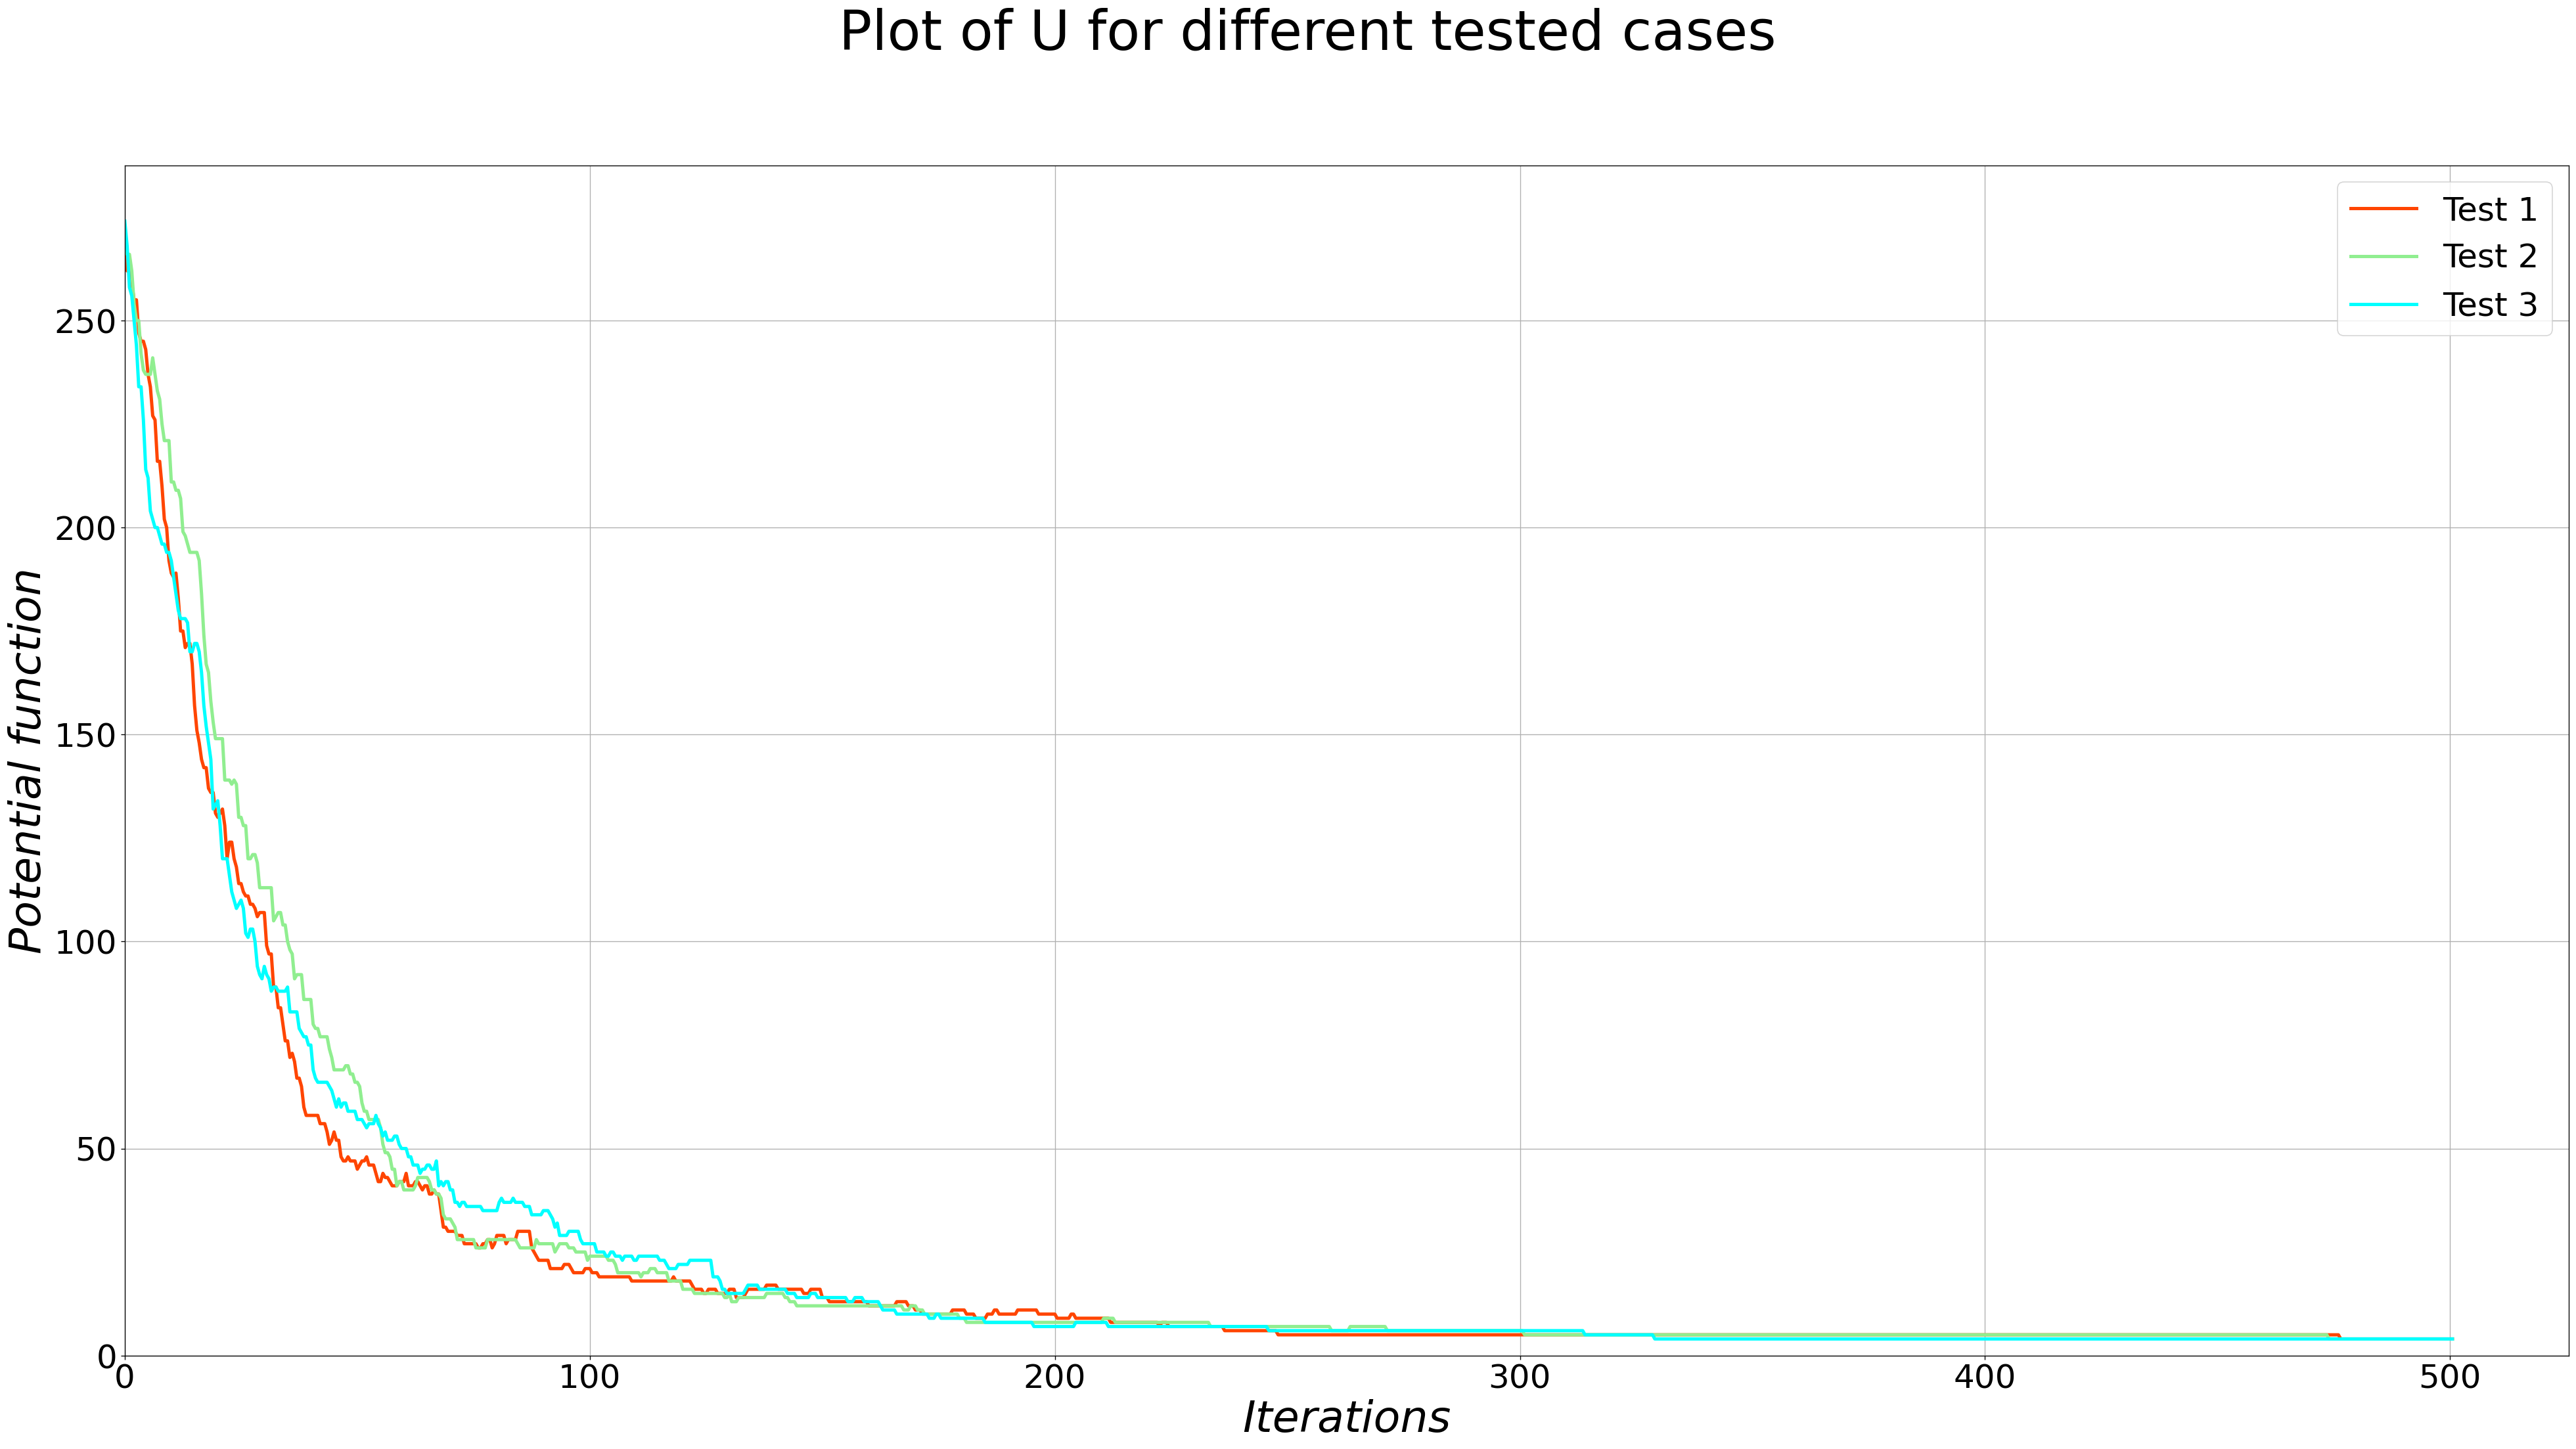

In [131]:
n_steps = 20
neighbours = create_neighbours(W)
all_u = []
for i in range(3):
    states_color = {i:'orangered' for i in G.nodes() }
    min_time_colors, u = learning_dynamics(G,neighbours,states_color, colors, routers = True, dict_of_COLORS = dict_of_COLORS)
    all_u.append(u)
U_plot(all_u, 5)

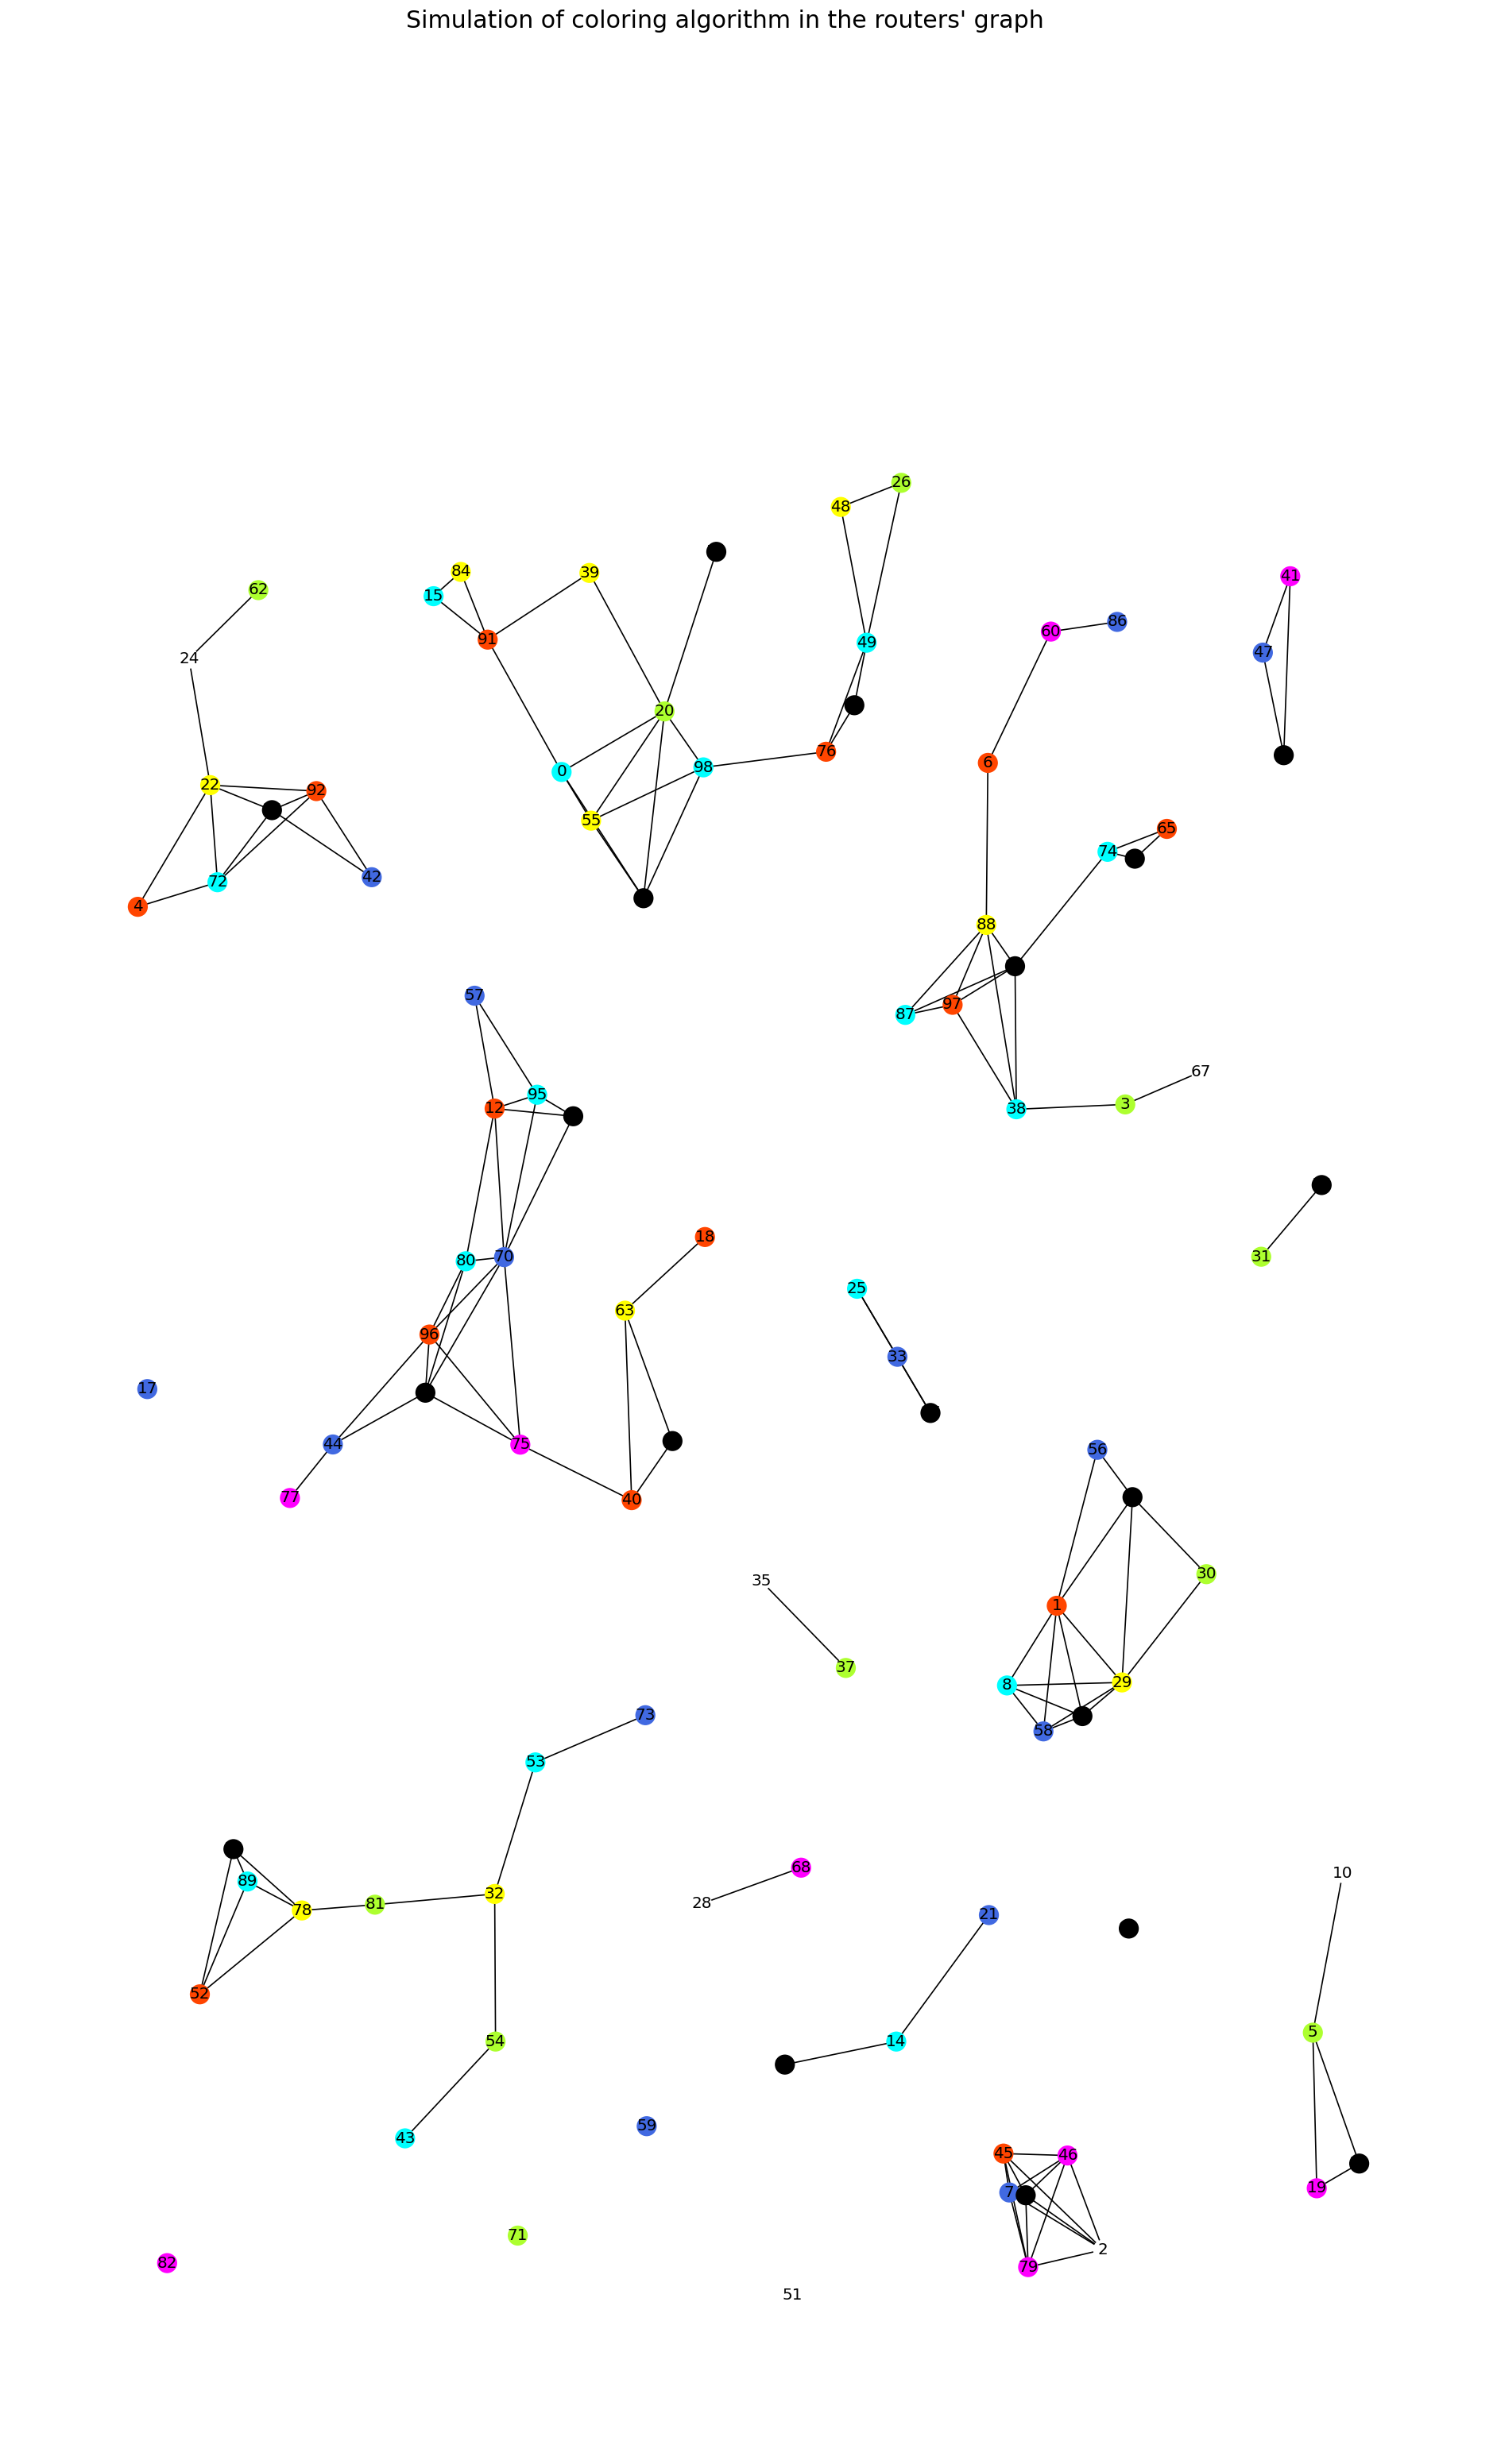

In [11]:
create_figure(G,4,'Simulation of coloring algorithm in the routers\' graph', POS ,node_color= min_time_colors,node_size = 200,figsize = (20,30))    

## Exploration for different values of $\eta$


Test 1
η, used: t/100
Potential function =  4.0 
found at time: 444
Test 2
η, used: 0.001
Potential function =  67.0 
found at time: 175
Test 3
η, used: 100
Potential function =  4.0 
found at time: 461
Test 4
η, used: exp(t/1000)
Potential function =  12.0 
found at time: 915
Test 5
η, used: log(t+2)
Potential function =  4.0 
found at time: 628
Test 6
η, used: sqrt(t)
Potential function =  4.0 
found at time: 992


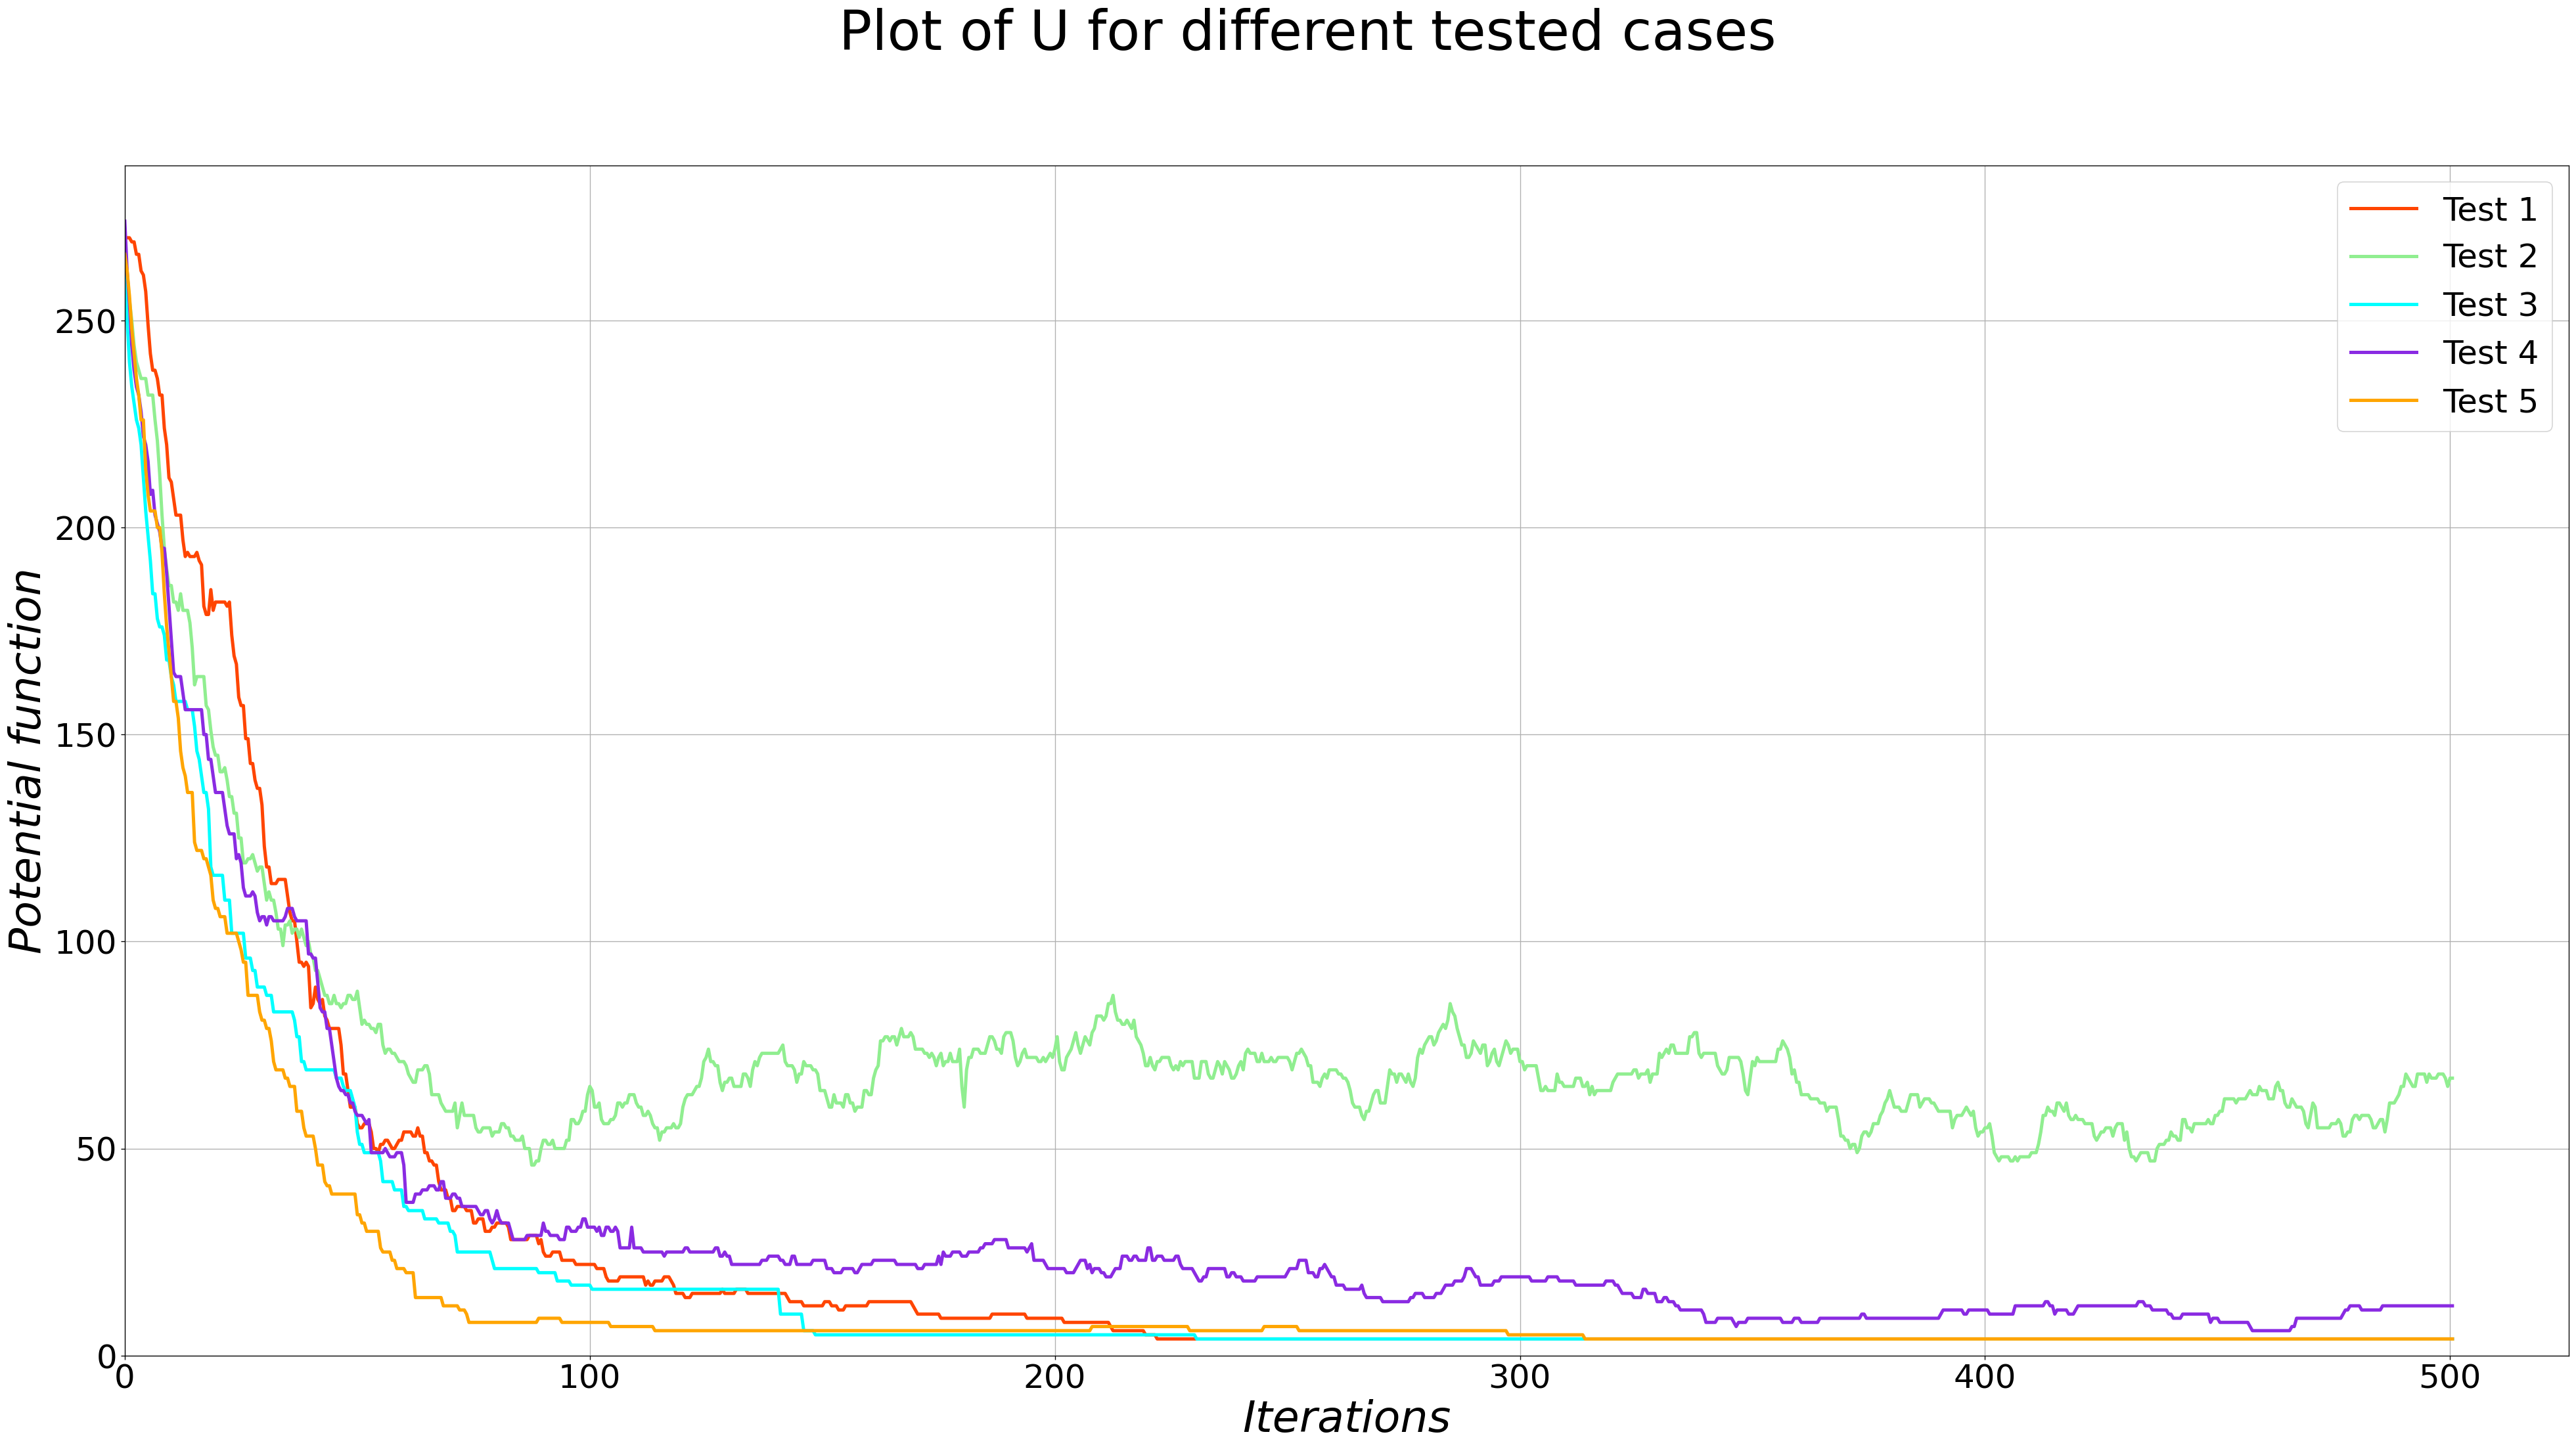

In [123]:
n_steps = 20
neighbours = create_neighbours(W)
all_u = []
ETA_possibles = {0: 't/100', 1:'0.001', 2: '100', 3:'exp(t/1000)' , 4:'log(t+2)', 5: 'sqrt(t)'}
for index in range(6):
    print(f'Test {index+1}')
    print('\u03b7, used:',ETA_possibles[index])
    states_color = {i:'orangered' for i in G.nodes() }
    min_time_colors, u = learning_dynamics(G,neighbours,states_color, colors, routers = True, dict_of_COLORS = dict_of_COLORS, index_eta = index)
    all_u.append(u)
U_plot(all_u, 6 , COLORS = ["orangered", "lightgreen", "aqua","blueviolet","orange"])